### Previsione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:

* id: id univoco dell'acquirente.
* Gender: sesso dell'acquirente.
* Age: età dell'acquirente.
* Driving_License: 1 se l'utente ha la patente di guida, 0 altrimenti.
* Region_Code: codice univoco della regione dell'acquirente.
* Previously_Insured: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.
* Vehicle_Age: età del veicolo
* Vehicle_Damage: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
* Annual_Premium: la cifra che l'utente deve pagare come premio durante l'anno.
* Policy_Sales_Channel: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)
* Vintage: numero di giorni dalla quale l'utente è cliente dell'azienda.
* Response: 1 se l'acquirente ha risposto positivamente alla proposta di vendita, 0 altrimenti.


L'obiettivo del modello è prevedere il valore di Response.

Tip Fai attenzione alla distribuzione delle classi, dai uno sguardo a questo approfondimento (https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). In caso di classi sbilanciate puoi provare a:

Penalizzare la classe più frequente (ricorda l'argomento class_weight)
Utilizzare l'oversampling o l'undersampling (https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/).

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

## Leggiamo il dataset e analizziamolo

In [36]:
df = pd.read_csv("insurance_cross_sell.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [37]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [38]:
df.shape

(381109, 12)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## Controllo se ci sono dati nulli e duplicati

In [40]:
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Non ci sono dati nulli

In [41]:
df.duplicated().any()

False

Non ci sono duplicati

#Exploratory Data Analysis

### Visualizzo i dati relativi alla feature "Response"

<ipython-input-42-805bc22fff08>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Response', data=df, palette=['orange', 'blue'])
<ipython-input-42-805bc22fff08>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['No', 'Yes'])


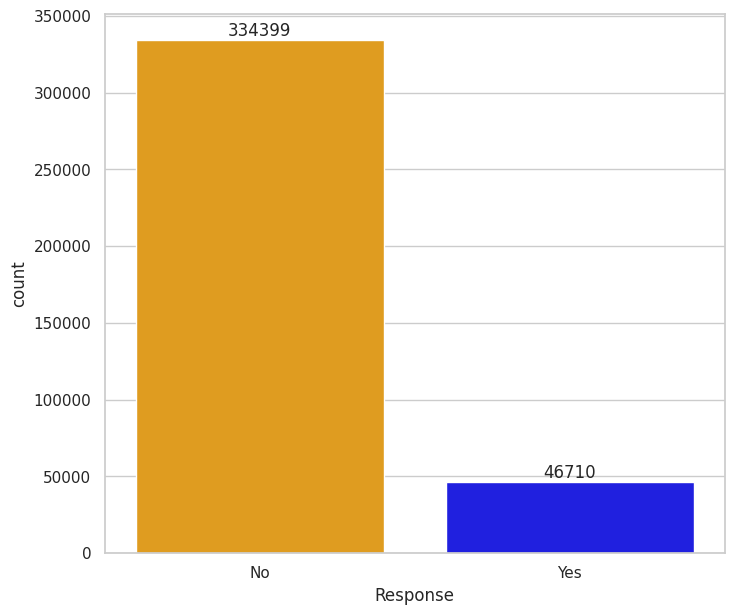

In [42]:
fig,ax = plt.subplots(figsize=(8,7))
sns.set_theme(style='whitegrid')
sns.countplot(x='Response', data=df, palette=['orange', 'blue'])
ax.bar_label(ax.containers[0]); ax.bar_label(ax.containers[1])
ax.set_xticklabels(['No', 'Yes'])
plt.show()

Possiamo notare dal grafico che i dati sono altamente sbilanciati

## Analizziamo anche il confronto tra le varie Features con il Target


### Age e Response



[Text(0.5, 1.0, 'Age and Response')]

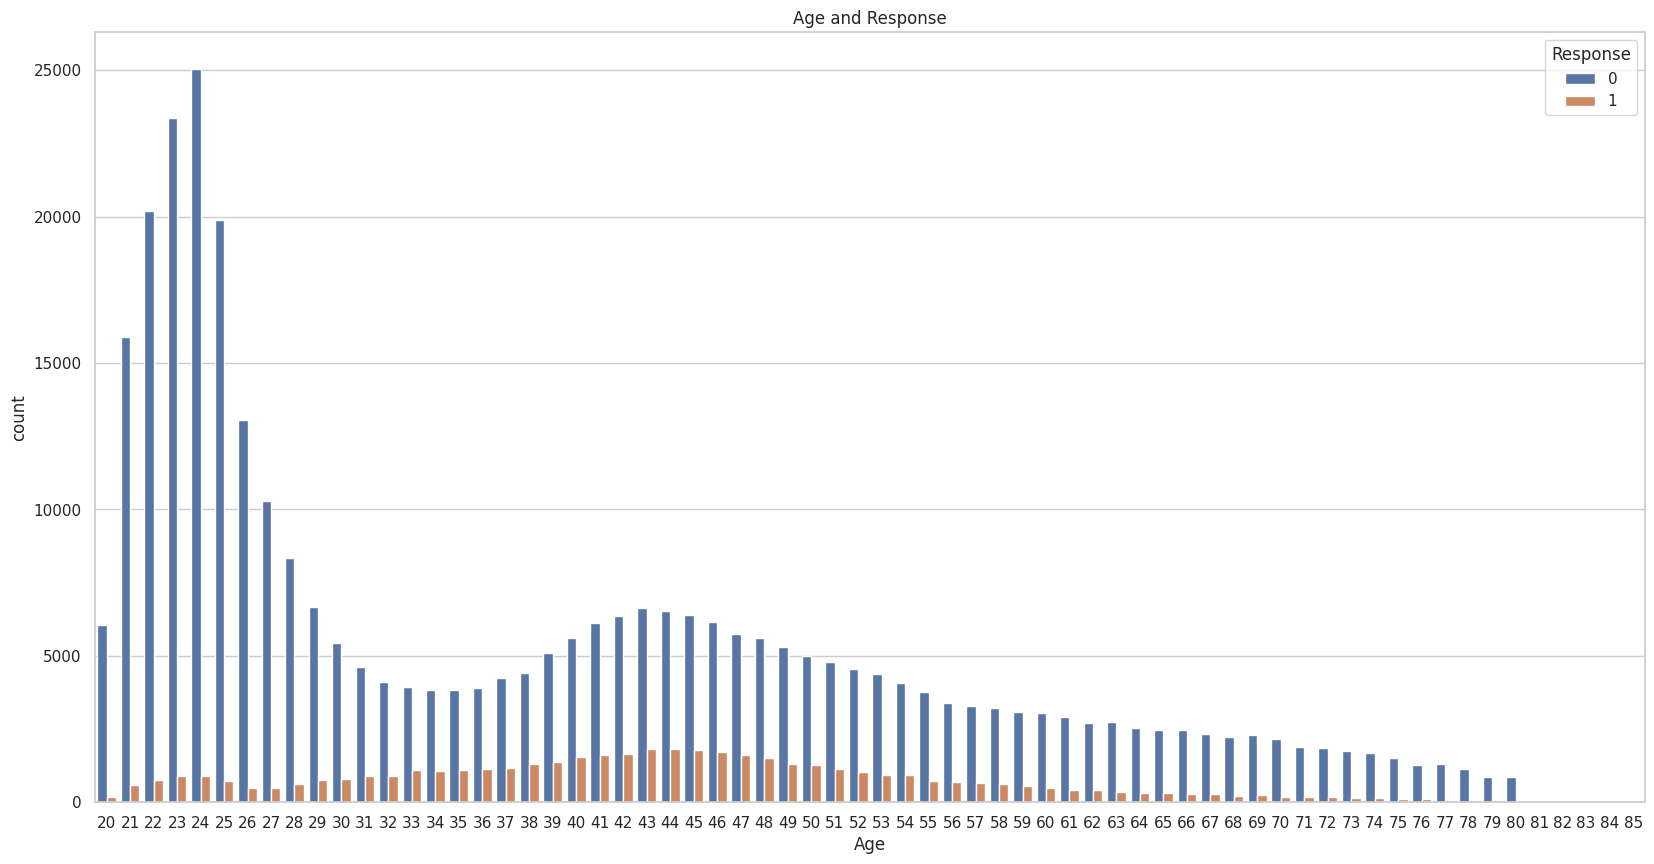

In [43]:
fig,ax=plt.subplots(figsize=(20,10))
sns.countplot(data= df, hue='Response',x='Age')
ax.set(title='Age and Response')

Si può notare che il range di età con maggiori probabilità di essere interessate all'assicurazione è compresa tra i 30 e i 60 anni.

### Gender and Response

<ipython-input-44-b2e5b8651c20>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Male', 'Female'])


[Text(0, 0, 'Male'), Text(1, 0, 'Female')]

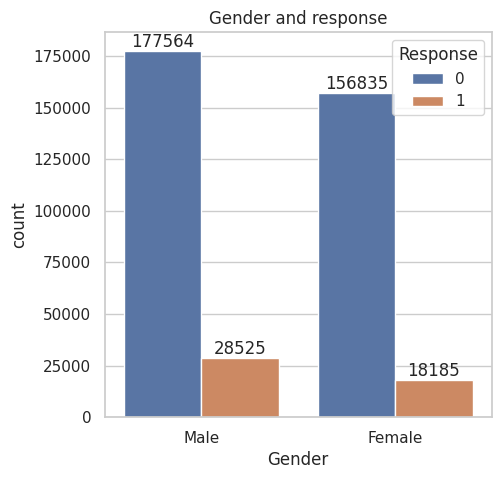

In [44]:
fig,ax=plt.subplots(figsize=(5,5))
sns.countplot(data=df,x= df['Gender'],hue= df['Response'] )
ax.bar_label(ax.containers[0]); ax.bar_label(ax.containers[1])
ax.set(title='Gender and response')
ax.set_xticklabels(['Male', 'Female'])

Per quanto riguarda il genere le distribuzioni sono abbastanza eque, la categoria maschile è di poco superiore di quella femminile.

### Driving License and Response

[Text(0.5, 1.0, 'Driving lincense and response')]

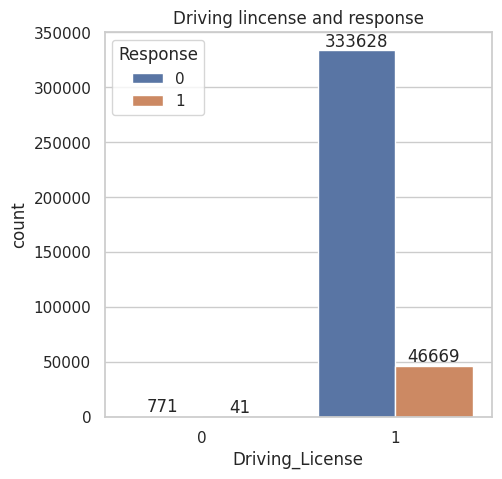

In [45]:
fig,ax=plt.subplots(figsize=(5,5))
sns.countplot(data=df,x='Driving_License',hue= 'Response')
ax.bar_label(ax.containers[0]); ax.bar_label(ax.containers[1])
ax.set(title='Driving lincense and response')



Possiamo vedere come i clienti interessati all'assicurazione sono quasi tutti in possesso di una patente

### Vechicle Damage and Response


[Text(0.5, 1.0, 'Vehicle_Damage and response')]

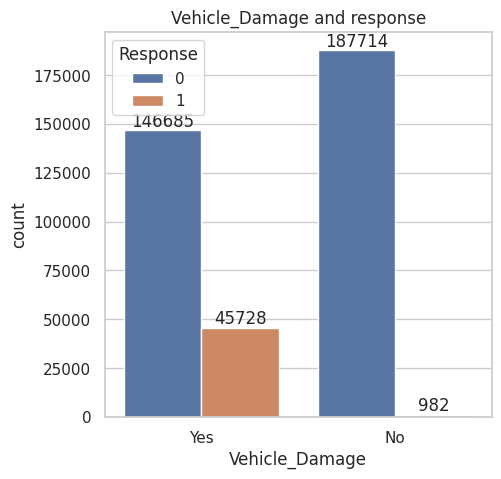

In [46]:
fig,ax=plt.subplots(figsize=(5,5))
sns.countplot(data=df,x='Vehicle_Damage',hue= 'Response', ax=ax)
ax.bar_label(ax.containers[0]); ax.bar_label(ax.containers[1])
ax.set(title='Vehicle_Damage and response')

Da questo grafico invece possiamo notare come i clienti che hanno subito danni al veicolo sono più interessati all'assicurazione.



### Vechicle Age and Response


[Text(0.5, 1.0, 'Vehicle_Age and response')]

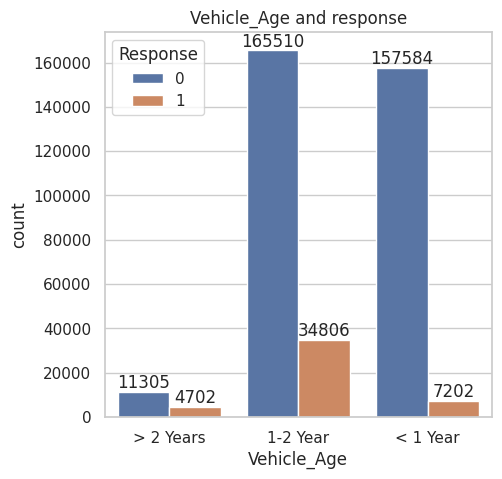

In [47]:
fig,ax=plt.subplots(figsize=(5,5))
sns.countplot(data=df,x='Vehicle_Age',hue= 'Response' )
ax.bar_label(ax.containers[0]); ax.bar_label(ax.containers[1])
ax.set(title='Vehicle_Age and response')

Si nota come clienti con età del veicolo di 1-2 anni sono più propensi ad assicurarsi rispetto agli altri

### Previously Insured and Response

[Text(0.5, 1.0, 'Previously_Insured v/s response')]

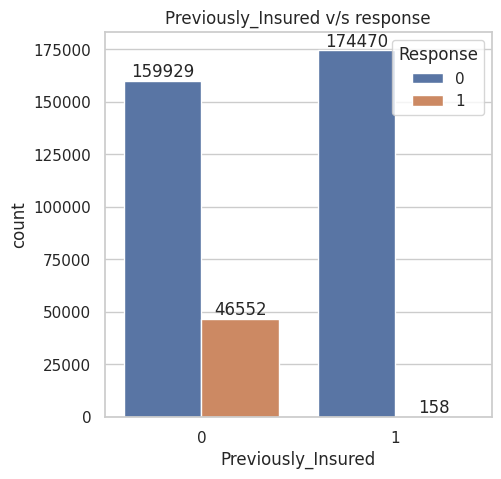

In [48]:
fig,ax=plt.subplots(figsize=(5,5))
sns.countplot(data=df,x='Previously_Insured',hue= 'Response' )
ax.bar_label(ax.containers[0]); ax.bar_label(ax.containers[1])
ax.set(title='Previously_Insured v/s response')

E' probabile che i clienti che non sono assicurati in precedenza siano interessati.

### Annual Premium and Response

<ipython-input-49-35e969465bf8>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[item])


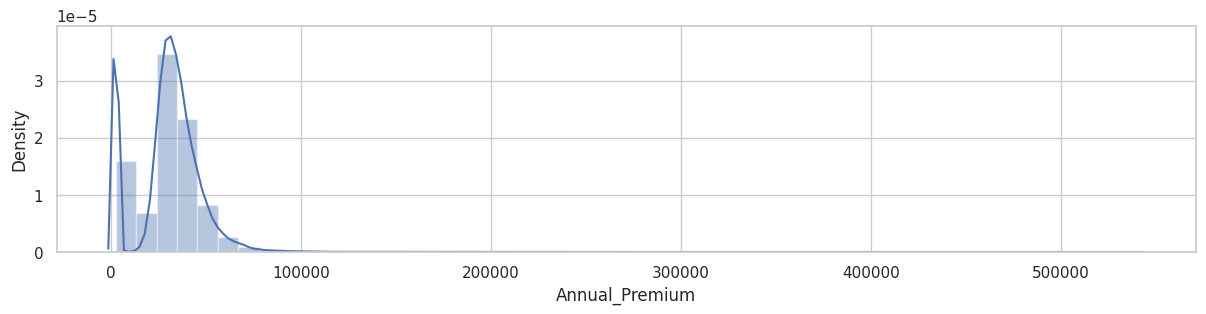

In [49]:
plt.figure(figsize=(50,10))
for index,item in enumerate(['Annual_Premium']):
  plt.subplot(3,3,index+1)
  sns.distplot(df[item])


Da questo grafico notiamo come la distribuzione dei valori per la variabile Annual_Premium è distorta

Controlliamo se per questa variabile sono presenti outliers tramite un grafico Boxplot

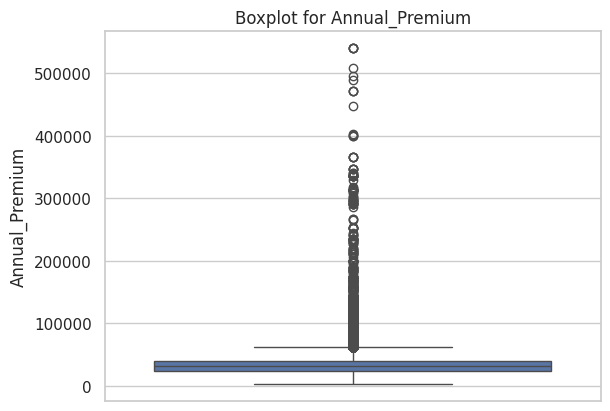

In [50]:
for col in ['Annual_Premium']:
    sns.boxplot(df[col])
    plt.title('Boxplot for Annual_Premium')
    plt.show()

Notiamo che sono presenti Outliers

Rimuoviamo gli outliers utilizzando il metodo IQR
(https://medium.com/@pp1222001/outlier-detection-and-removal-using-the-iqr-method-6fab2954315d)

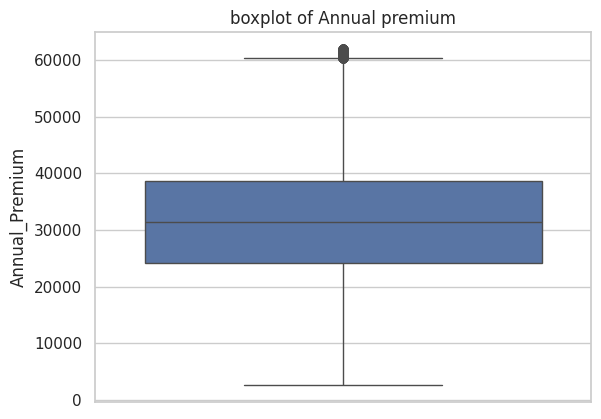

In [51]:
q1 = df['Annual_Premium'].quantile(0.25)
q3 = df['Annual_Premium'].quantile(0.75)
iqr = q3 - q1

# Calculate the lower and upper bounds for outliers
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

# Remove outliers from the "Annual_Premium" column
df = df[(df['Annual_Premium'] >= lower_bound) & (df['Annual_Premium'] <= upper_bound)]

sns.boxplot(df['Annual_Premium'])
plt.title("boxplot of Annual premium")
plt.show()


Outliers Rimossi !

### Confusion Matrix

Selezionare solo le colonne numeriche per il calcolo della correlation matrix

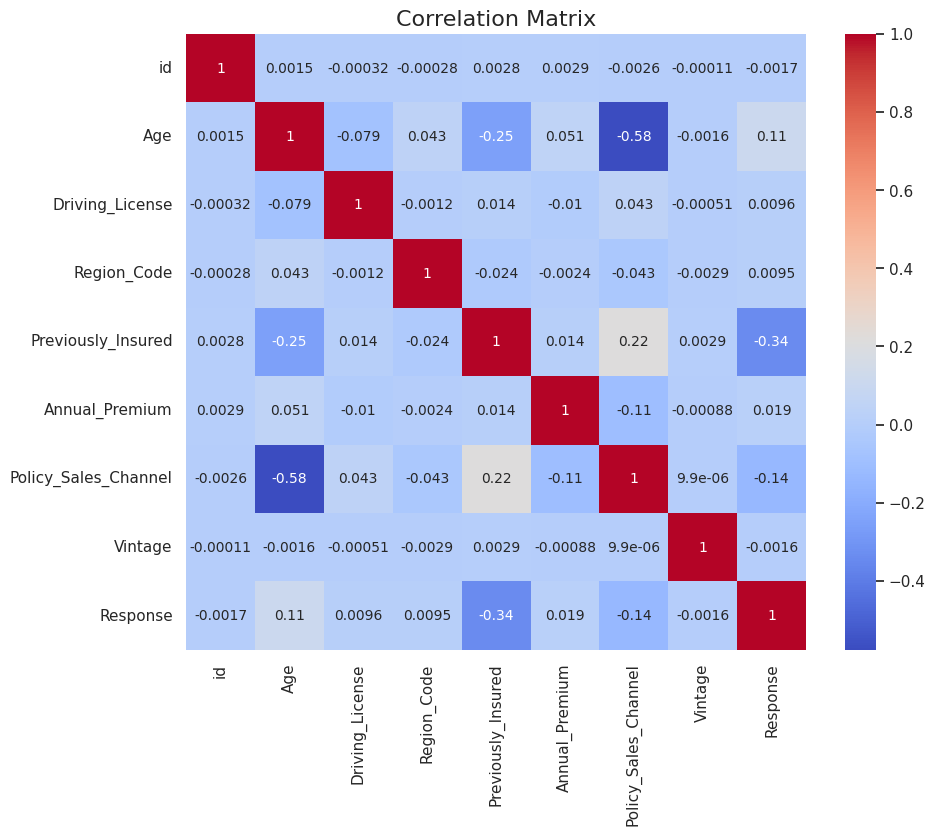

In [52]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 10})
plt.title('Correlation Matrix', size=16)
plt.show()

Dalla Matrice di Correlazione possiamo notare che la variabile target "Response" è poco correlata con la variabile "Vintage", notiamo infatti un valore prossimo allo 0.

Cosi come il valore di id che è un valore non significatico essendo un valore univoco non contiene informazioni utili per l'analisi.

Andiamo quindi ad escludere dall'analisi queste due feature!

In [53]:
df.drop(['id'],axis=1 ,inplace=True)

df.drop(['Driving_License'],axis=1 ,inplace=True)

# Encoding
Convertiamo le variabili categoriche Gender, Vehicle_Age e Veichle_Damage in variabili numeriche facendo Label Encoding

In [54]:
df['Gender'] = df['Gender'].map({'Female':1, 'Male':0})

df['Vehicle_Age']= df['Vehicle_Age'].map({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})

df['Vehicle_Damage']=df['Vehicle_Damage'].map({'Yes':1, 'No':0})

df.head()


,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,44,28.0,0,2,1,40454.0,26.0,217,1
1,0,76,3.0,0,1,0,33536.0,26.0,183,0
2,0,47,28.0,0,2,1,38294.0,26.0,27,1
3,0,21,11.0,1,0,0,28619.0,152.0,203,0
4,1,29,41.0,1,0,0,27496.0,152.0,39,0


### Separiamo adesso le variabili indipendenti dalla variabile target :

In [55]:
x=df.drop(['Response'],axis=1)
y=df['Response']

## Gestione dei dati sbilanciati tramite OverSampling

In [56]:
from imblearn.over_sampling import RandomOverSampler

random_sample = RandomOverSampler()
x_new,y_new = random_sample.fit_resample(x,y)

In [57]:
from collections import Counter
print('Dimensione del Dataset originale {}'.format(Counter(y)))
print('Dimensione del Dataset dopo Oversampling {}'.format(Counter(y_new)))

Dimensione del Dataset originale Counter({0: 325634, 1: 45155})
Dimensione del Dataset dopo Oversampling Counter({1: 325634, 0: 325634})


## Train e Test data

Creaiamo adesso i set di training e testing

In [58]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x_new,y_new,test_size=.30,random_state=0)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(455887, 9) (195381, 9) (455887,) (195381,)


## Feature Scaling

Facciamo feature scaling in modo da avere tutte le features in un intervallo di valori simile tra loro.

In [59]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

## Logistic Regression

Addestriamo adesso un primo modello tramite Regressione Logistica e analizziamo i risultati tramite matrice di confusione e ROC curve

[[58144 39671]
 [ 2359 95207]]
L'accuratezza per la Regressione logistica è : 0.7848818462388871


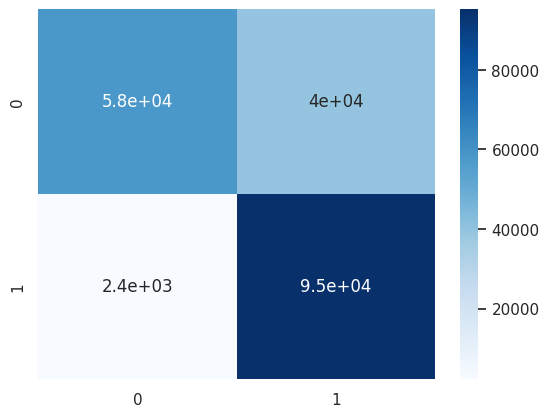

In [60]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
acc_lr= accuracy_score(y_test,y_pred)
recall_lr = recall_score(y_test,y_pred)
precision_lr = precision_score(y_test,y_pred)
f1score_lr= f1_score(y_test,y_pred)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix
print(confusion_matrix(y_test,y_pred))

cm = confusion_matrix(y_test,y_pred)
#print(cm)
sns.heatmap(cm,annot=True,cmap='Blues')

acc = accuracy_score(y_test,y_pred)
print("L'accuratezza per la Regressione logistica è :",acc)

In [61]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.59      0.73     97815
           1       0.71      0.98      0.82     97566

    accuracy                           0.78    195381
   macro avg       0.83      0.79      0.78    195381
weighted avg       0.83      0.78      0.78    195381



ROC_AUC Score of Logistic regression is : 0.8334425683375211


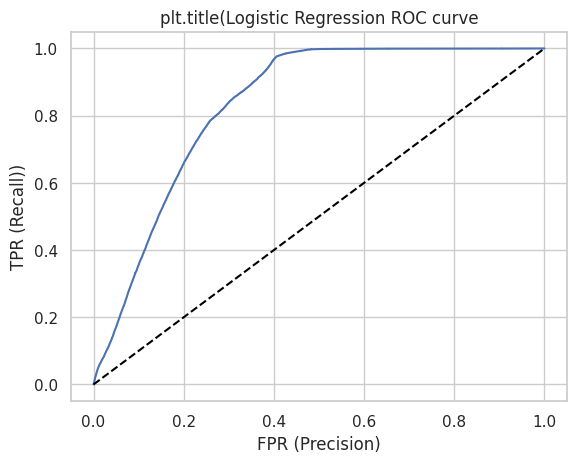

In [62]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
AUC_LR=roc_auc_score(y_pred,y_test)
print("ROC_AUC Score of Logistic regression is :",AUC_LR)

y_score = lr.predict_proba(x_test)[:, 1]

y_true = y_test

pos_label = 1

fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

plt.title('plt.title(Logistic Regression ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall))')
plt.xlabel('FPR (Precision)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.grid(True)
plt.show()

Proviamo ad addestrare altri due modelli e vediamo se danno risultati migliori rispetto alla Regressione Logistica.

### KNeighborsClassifier

[[73133 24682]
 [ 3402 94164]]
L'accuratezza per knn è:  0.856260332376229


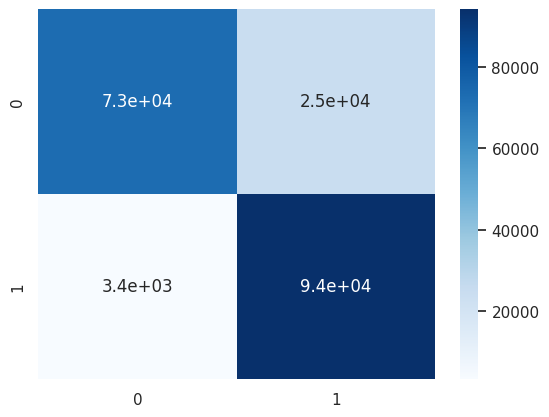

In [63]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(5)
knn.fit(x_train,y_train)
pred = knn.predict(x_test)

from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
acc_knn = accuracy_score(y_test,pred)
recall_knn  = recall_score(y_test,pred)
precision_knn = precision_score(y_test,pred)
f1score_knn = f1_score(y_test,pred)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix

print(confusion_matrix(y_test,pred))
cm = confusion_matrix(y_test,pred)
#print(cm)
sns.heatmap(cm,annot=True,cmap='Blues')

print("L'accuratezza per knn è: ",accuracy_score(y_test,pred))

In [64]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.96      0.75      0.84     97815
           1       0.79      0.97      0.87     97566

    accuracy                           0.86    195381
   macro avg       0.87      0.86      0.85    195381
weighted avg       0.87      0.86      0.85    195381



ROC_AUC Score of KNN is: 0.8739346103696518


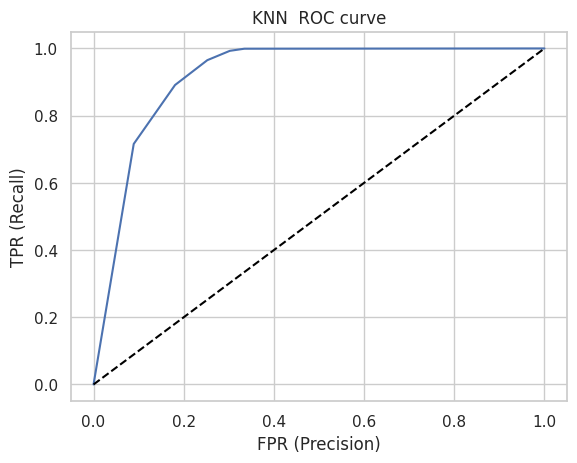

In [65]:
AUC_knn=roc_auc_score(pred,y_test)
print("ROC_AUC Score of KNN is:",AUC_knn)

y_score = knn.predict_proba(x_test)[:, 1]

y_true = y_test

pos_label = 1

fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

plt.title('KNN  ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.grid(True)
plt.show()

### Random Forest

[[86797 11018]
 [  324 97242]]


<Axes: >

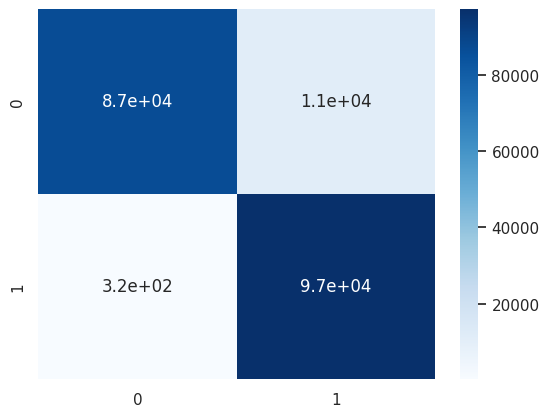

In [66]:
from sklearn .ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
rf_pred= rf.predict(x_test)

from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
acc_rf = accuracy_score(y_test,rf_pred)
recall_rf  = recall_score(y_test,rf_pred)
precision_rf = precision_score(y_test,rf_pred)
f1score_rf = f1_score(y_test,rf_pred)

print(confusion_matrix(y_test,rf_pred))

cm = confusion_matrix(y_test,rf_pred)
#print(cm)
sns.heatmap(cm,annot=True,cmap='Blues')

In [67]:
print("L'accuratezza per Random Forest è: ", accuracy_score(y_test,rf_pred))

L'accuratezza per Random Forest è:  0.9419493195346528


In [68]:
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     97815
           1       0.90      1.00      0.94     97566

    accuracy                           0.94    195381
   macro avg       0.95      0.94      0.94    195381
weighted avg       0.95      0.94      0.94    195381



In [69]:
AUC_rf=roc_auc_score(rf_pred,y_test)
print("ROC_AUC Score of Random Forest is:",AUC_rf)

ROC_AUC Score of Random Forest is: 0.9472537631012193


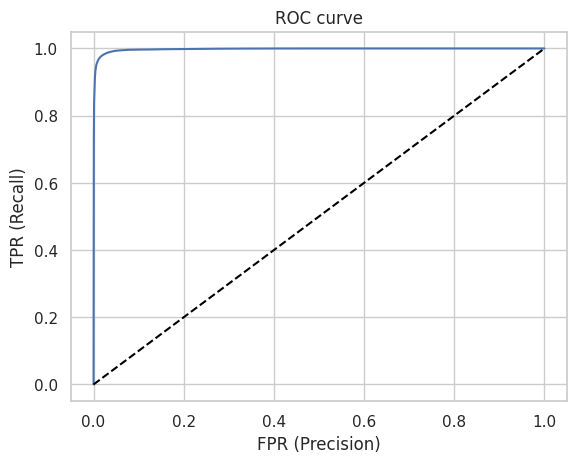

In [70]:

y_score = rf.predict_proba(x_test)[:, 1]

y_true = y_test

pos_label = 1

fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.grid(True)
plt.show()


## Confronto finale

Per finire facciamo un confronto tra i tre modelli proposti per vedere insieme tutti i risultati.

Notiamo come il modello di Random Forest da un risultato nettamente migliore agli altri due con un'accuracy del 94%.

In [71]:
model_name =['Logistic regression', 'KNeighbors','Randomforest']

data={"Accuracy":[acc_lr,acc_knn,acc_rf],"Recall":[recall_lr,recall_knn,recall_rf],
      "Precision":[precision_lr,precision_knn,precision_rf],
    'f1_score':[f1score_lr,f1score_knn,f1score_rf],
    "ROC_AUC":[AUC_LR,AUC_knn,AUC_rf]}

result=pd.DataFrame(data=data,index=model_name)
result

,Accuracy,Recall,Precision,f1_score,ROC_AUC
Logistic regression,0.784882,0.975821,0.705875,0.819182,0.833443
KNeighbors,0.856260,0.965131,0.792319,0.870229,0.873935
Randomforest,0.941949,0.996679,0.898226,0.944895,0.947254
